# Perform read smoothing then assemble with LJA

In [2]:
%run "Header.ipynb"
%run "../main-workflow/utils.py"

In [3]:
import os
import time
import pickle
import pysam
import skbio
from collections import defaultdict, Counter
from statistics import mean
from linked_mutations_utils import find_mutated_positions

## 0. Quick sanity check: ensure that all $k$-mers ($k$ = 5,001) are unique in each MAG

In [3]:
# (Commenting out for now, because I've already checked this and I don't see any reason to keep rerunning this
# for the same set of MAGs.)
# # I know there are actual k-mer counting tools you can use but no reason to overcomplicate things for now

# k = 5001

# for seq in SEQS:
#     fasta = skbio.DNA.read(f"../seqs/{seq}.fasta")
#     bargain_bin_kmer_counter = Counter()
    
#     # The skbio.DNA object is 0-indexed, so 0 is the leftmost k-mer start position and
#     # ((seq length) - k) is the rightmost k-mer start position. The + 1 is because python ranges don't include
#     # the right endpoint.
#     for start_pos in range(0, seq2len[seq] - k + 1):
        
#         # NOTE: this is a terrible no good very bad way to do this; it's more efficient to use a "sliding window"
#         # approach where you store the entire k-mer and then, with each step, just remove the first character and
#         # add on a new last character. "But, uh, this code will only be run on these three MAGs, so I'm gonna
#         # prioritize clarity over optimization," says me, the insane person who just spent like a minute writing
#         # this comment when I could've been optimizing this code instead look WHATEVER this counts k-mers and it's
#         # 4am let's not overcomplicate it, look if you're on GitHub right now and you see this inane comment
#         # we can both just pretend that you were looking at some really optimized code and we'll both walk away
#         # satisfied, capisce
#         kmer = fasta[start_pos : start_pos + k]
        
#         bargain_bin_kmer_counter[str(kmer)] += 1
#         if start_pos % 1000000 == 0: print(f"On start pos {start_pos:,} in {seq2name[seq]}.")
    
#     mckc = bargain_bin_kmer_counter.most_common(1)[0][1]
#     print(f"The most common k = {k:,}-mer in {seq2name[seq]} occurred {mckc:,} time(s).")

## 1. Smooth reads

Lots of this code is duplicated from the `Phasing-01-MakeGraph.ipynb` notebook in this folder.

In [4]:
# Set this to True to actually generate ordinary smoothed reads that include called mutations;
# set this to False to generate "sanity check" perfect smoothed reads, where no mutations are included
# and the read entirely matches the reference
actually_include_mutations_in_the_smoothed_reads = True

add_virtual_reads = True

In [5]:
# We'll need to know the mean coverage of each sequence when computing virtual reads.
seq2meancov = get_meancovs()
seq2meancov

Sequence edge_6104 has average coverage 4,158.57 and median coverage 4,122.00.
Sequence edge_1671 has average coverage 1,415.07 and median coverage 1,436.00.
Sequence edge_2358 has average coverage 2,993.46 and median coverage 2,936.00.


{'edge_6104': 4158.572468826692,
 'edge_1671': 1415.072755380576,
 'edge_2358': 2993.461913625056}

In [6]:
bf = pysam.AlignmentFile("../main-workflow/output/fully-filtered-and-sorted-aln.bam", "rb")
output_dir = "phasing-data/smoothed-reads/"

# verbose?
no_indoor_voice = False

def write_out_reads(filepath, readname2seq):
    # Notably, this uses the "a" (append) method in order to add to the end of a file.
    # Be careful -- if you're rerunning this, you'll 
    with open(filepath, "a") as of:
        for readname in readname2seq:
            # Write out both the header and the sequence for each read
            of.write(f">{readname}\n{str(readname2seq[readname])}\n")
            
ALN_UPDATE_FREQ = 5000
ALN_BUFFER_FREQ = 1000
VR_EXTRA_SPAN = 100
# in the range [0, 1]
MIN_WELL_COV_FRAC = 0.95

P = 1

t1 = time.time()
for seq in SEQS:
    
    # How much coverage does a given position require to be classified as not "low coverage"?
    # Defined as some fraction of the average coverage of this MAG.
    min_well_cov = MIN_WELL_COV_FRAC * seq2meancov[seq]
    
    # As we construct smoothed reads, identify which positions (0-indexed) have
    # "low coverage" (a coverage of < min_well_cov). We'll add "virtual reads" that
    # span runs of these positions.
    pos2srcov = {pos: 0 for pos in range(0, seq2len[seq])}
    
    fasta = skbio.DNA.read(f"../seqs/{seq}.fasta")
    
    output_smoothed_reads_file = os.path.join(output_dir, f"{seq}_smoothed_reads_delignore_vrlow.fasta")
    try:
        os.remove(output_smoothed_reads_file)
    except FileNotFoundError:
        # it's fine if this file doesn't exist yet. what we DON'T want to happen is this file to already exist after
        # this point in the code; since we only use "append" file-writing to write out smoothed reads, if we don't
        # manually remove this file then running this script twice will cause weird behavior where the file contains
        # the same smoothed reads multiple times, etc.
        pass
    
    # Identify all (0-indexed, so compatible with skbio / pysam!)
    # mutated positions in this genome up front to save time.
    #
    # Equivalently, we could also just take in an arbitrary VCF as input
    # (e.g. one produced from another variant calling tool), although we'd
    # need to be careful to only include SNVs and not indels/etc...
    
    print("=" * 70)
    print(f"Identifying mutated positions (p = {P}%) in genome {seq2name[seq]}...")
    mutpos2pileup = find_mutated_positions(seq, p_to_use=P, incl_pileup=True)
    # We sort because the code below relies on these being in ascending order
    mutated_positions = sorted(mutpos2pileup.keys())
    print(f"Found {len(mutated_positions):,} mutated positions (p = {P}%) in {seq2name[seq]}.")
    print(
        f"Note that this tally is higher than you'd see in e.g. the CP1/2/3 plots, because now we're including "
        "both 'rare' and non-rare mutations. Just so you don't waste five minutes sanity-checking this like I did."
    )
    
    print("Going through these positions...")
    
    num_ignored_alns = 0
    
    # Instead of just writing out every smoothed alignment as soon as we generate it, we build up a "buffer"
    # of these alignments and then write a bunch out at once. This way we limit slowdown due to constantly
    # having to open/close files. I don't really have a good source for this as best practice, but I remembered
    # to do it while writing this code, so somewhere in College Park the CS faculty at Maryland are smiling
    #
    # Also fyi this maps read name to smoothed alignment (well, at this point, just read) sequence. The read name
    # is useful to preserve in fasta files so we have some idea of provenance (where smoothed reads came from)
    smoothed_aln_buffer = {}
    
    # The first time we see an alignment of a read, it's 1; if we see a supp aln of this read, it's 2; etc.
    # Lets us distinguish alignments with different names
    readname2freq_so_far = defaultdict(int)
    
    # Go through all linear alignments of each read to this genome, focusing (for now) on just the primary
    # alignments...
    ts1 = time.time()
    for ai, aln in enumerate(bf.fetch(seq), 1):
        
        if ai % ALN_UPDATE_FREQ == 0:
            print(
                f"\tOn aln {ai:,} in seq {seq2name[seq]}. "
                f"Time spent on {seq2name[seq]} so far: {time.time() - ts1:,.2f} sec."
            )
            
        if aln.is_secondary:
            raise ValueError(
                "Not to get political or anything, but you should've already filtered secondary alns out"
            )
            
        # Note that supplementary alignments are ok, though! We implicitly handle these here.
        #
        # Different alignments of the same read will have different new_readnames, because we're gonna
        # be treating them as distinct "reads". We should have already filtered reference-overlapping
        # supp alns so this shouldn't be a problem
        
        readname = aln.query_name
        readname2freq_so_far[readname] += 1
        new_readname = f"{readname}_{readname2freq_so_far[readname]}"
        
        # should never happen
        if new_readname in smoothed_aln_buffer:
            raise ValueError("This exact read alignment has already been smoothed? Weird.")
            
        # Figure out where on the MAG this alignment "hits." These are 0-indexed positions from Pysam.
        # (reference_end points to the position after the actual final position, since these are designed to
        # be interoperable with Python's half-open intervals.)
        #
        # Of course, there likely will be indels within this range: we're purposefully ignoring those here.
        ref_start = aln.reference_start
        ref_end = aln.reference_end - 1
        
        # This should never happen (TM)
        if ref_start >= ref_end:
            # Du sollst jetzt mit Gott sprechen.
            raise ValueError(
                f"Ref start {ref_start:,} >= ref end {ref_end:,} for read {new_readname}?"
            )
            
        # Smoothed sequence; we'll edit this so that if this read has (mis)matches to any called mutated
        # positions, these positions are updated with the read's aligned nucleotides at these positions.
        smoothed_aln_seq = fasta[ref_start: ref_end + 1]
        
        if actually_include_mutations_in_the_smoothed_reads:
            # just for debugging: track the exact edits made to smoothed_aln_seq
            replacements_made = {}

            # We may choose to ignore this linear alignment, if we think it is error-prone or
            # otherwise not useful. If this gets set to True in the loop below, then we'll notice this
            # and ignore this alignment.
            ignoring_this_aln = False
            
            # Notably, include skips -- this way, we can figure out if the aln has a deletion at a mutated
            # position, and if so ignore this aln
            ap = aln.get_aligned_pairs(matches_only=False)

            # Iterating through the aligned pairs is expensive. Since read lengths are generally in the thousands
            # to tens of thousands of bp (which is much less than the > 1 million bp length of any bacterial genome),
            # we set things up so that we only iterate through the aligned pairs once. We maintain an integer, mpi,
            # that is a poor man's "pointer" to an index in mutated_positions.

            mpi = 0

            # Go through this aln's aligned pairs. As we see each pair, compare the pair's reference position
            # (refpos) to the mpi-th mutated position (herein referred to as "mutpos").
            #
            # If refpos >  mutpos, increment mpi until refpos <= mutpos (stopping as early as possible).
            # If refpos == mutpos, we have a match! Update readname2mutpos2ismutated[mutpos] based on
            #                      comparing the read to the reference at the aligned positions.
            # If refpos <  mutpos, continue to the next pair.

            for pair in ap:

                refpos = pair[1]
                
                # Since we set matches_only (for get_aligned_pairs()) to False, the alignment could include
                # insertions (which are encoded as the reference pos being set to None). We inherently ignore
                # these insertions as part of the read smoothing process.
                if refpos is None:
                    continue
                    
                mutpos = mutated_positions[mpi]

                no_mutations_to_right_of_here = False

                # Increment mpi until we get to the next mutated position at or after the reference pos for this
                # aligned pair (or until we run out of mutated positions).
                while refpos > mutpos:
                    mpi += 1
                    if mpi < len(mutated_positions):
                        mutpos = mutated_positions[mpi]
                    else:
                        no_mutations_to_right_of_here = True
                        break

                # I expect this should happen only for reads aligned near the right end of the genome.
                if no_mutations_to_right_of_here:
                    break

                # If the next mutation occurs after this aligned pair, continue on to a later pair.
                if refpos < mutpos:
                    continue

                # If we've made it here, refpos == mutpos!
                # (...unless I messed something up in how I designed this code.)
                if refpos != mutpos:
                    raise ValueError("This should never happen!")

                # Finally, get the nucleotide aligned to this mutated position from this read.
                readpos = pair[0]
                
                # Since we set matches_only (for get_aligned_pairs()) to False, there's a chance a read
                # contains deletions aligned to mutated positions. This is accounted for by this case.
                # If this happens, we ignore this alignment (the same as if it would contain a nt that
                # isn't the first or second most common).
                if readpos is None:
                    if no_indoor_voice:
                        print(
                            f"Read {new_readname} has deletion at mutpos {mutpos + 1:,}: "
                            f"pileup = {mutpos2pileup[mutpos]}"
                        )
                    ignoring_this_aln = True
                    break
                    
                read_nt = aln.query_sequence[readpos]

                # If this aln doesn't have match the first or second most common nucleotide at this position,
                # ignore it. In the future, when we perform read  smoothing based on an arbitrary set of
                # SNV calls, we can be more careful about this; but for now we make the simplifiying assumption
                # that a mutation likely only has one alternate nucleotide, and that the 3rd and 4th most
                # common nucleotides indicate errors. (Also, note that we break ties here arbitrarily.)
                nt2ct = dict(zip("ACGT", mutpos2pileup[mutpos][0]))
                nt1 = max(nt2ct, key=nt2ct.get)
                del nt2ct[nt1]
                nt2 = max(nt2ct, key=nt2ct.get)
                
                if read_nt != nt1 and read_nt != nt2:
                    if no_indoor_voice:
                        print(
                            f"Read {new_readname} has 3rd or 4th most common nt at mutpos {mutpos + 1:,}: "
                            f"pileup = {mutpos2pileup[mutpos]}, read = {read_nt}"
                        )
                    ignoring_this_aln = True
                    break
                    
                # Notably, the nucleotide at a mutated position in a smoothed read will always be the first
                # or second most common nucleotide at this position. So "unreasonable" positions, in which
                # the ref nt != the consensus nt, will not be treated as you might expect -- we ignore the
                # reference in this particular case. Shouldn't make a big difference, since in most cases
                # the ref and consensus nt agree.
                #
                # Note that we aren't even looking at the reference nt at this point -- in many cases
                # the .replace() operation done below won't change anything. Shouldn't matter.
                relative_pos_on_aln = mutpos - ref_start
                smoothed_aln_seq = smoothed_aln_seq.replace([relative_pos_on_aln], read_nt)
                replacements_made[relative_pos_on_aln] = read_nt
                if no_indoor_voice:
                    print(
                        f"Updated read {new_readname} re: nt at mutpos {mutpos + 1:,}: "
                        f"pileup = {mutpos2pileup[mutpos]}, read = {read_nt}"
                    )

            if no_indoor_voice:
                print(f"Read {new_readname} involved {len(replacements_made):,} replacements!")
        
        if ignoring_this_aln:
            num_ignored_alns += 1
        else:
            # Now that we've finished processing all called mutations that this alignment spans, prepare it
            # to be written out to a FASTA file. See comments above on smoothed_aln_buffer, and why we don't
            # just write everything out as soon as it's ready.
            #
            # (Also, we've already guaranteed readname isn't already in smoothed_aln_buffer, so no need to worry
            # about accidentally overwriting something from earlier.)
            smoothed_aln_buffer[new_readname] = smoothed_aln_seq

            # Record which positions this smoothed read covers (of course, the original read may not exactly
            # "cover" these positions due to indels, but the smoothed version will cover them).
            #
            # We purposefully delay performing this update until right now -- this way, if we choose to "ignore"
            # this linear alignment at any point in the process above, we won't increase anything in pos2srcov
            # for this linear alignment.
            for pos_in_sr in range(ref_start, ref_end + 1):
                pos2srcov[pos_in_sr] += 1

            if ai % ALN_BUFFER_FREQ == 0:
                write_out_reads(output_smoothed_reads_file, smoothed_aln_buffer)
                # Clear the buffer
                smoothed_aln_buffer = {}
        
    # We're probably going to have left over smoothed reads that we still haven't written out, unless things
    # worked out so that on the final alignment we saw ai was exactly divisible by ALN_BUFFER_FREQ (and that's
    # pretty unlikely unless you set the buffer freq to a low number). So make one last dump of the buffer.
    if len(smoothed_aln_buffer) > 0:
        write_out_reads(output_smoothed_reads_file, smoothed_aln_buffer)
        
    print(f"We ignored {num_ignored_alns:,} linear alignments, fyi.")
    
    low_cov_positions = []
    for pos in range(0, seq2len[seq]):
        if pos2srcov[pos] < min_well_cov:
            low_cov_positions.append(pos)
    
    if add_virtual_reads and len(low_cov_positions) > 0:
        print(f"For reference, there are {len(low_cov_positions):,} low-coverage positions in {seq2name[seq]}.")
        
        # convert_to_runs (which is defined in Header.ipynb, btw) depends on the input list being sorted.
        # This is implicitly true because of how we constructed low_cov_positions above, so we're good.
        lc_runs = convert_to_runs(low_cov_positions)
        print(f'And there are {len(lc_runs)} "runs" of low-coverage positions.')
        print(lc_runs)
        
        print(f'Adding "virtual reads" spanning each of these runs to account for this...')
        
        # Sanity check: if the MAG is bizarrely short relative to the virtual read spanning stuff, complain
        # (We could probably move this sanity check to further up in the code if this becomes a problem, but
        # I don't think this is a big deal -- esp since short MAGs imply the above read smoothing stuff going
        # by relatively quickly, right?)
        if seq2len[seq] <= (2 * VR_EXTRA_SPAN):
            raise ValueError(
                f"Sequence {seq} has a length of {seq2len[seq]:,}. "
                f"This cannot be <= (2 * VR_EXTRA_SPAN), which is {2 * VR_EXTRA_SPAN:,}."
            )
        
        num_vr = 0
        vr_buffer = {}
        for run in lc_runs:
            
            # How many copies of this virtual read should we add?
            # Our goal is, essentially, "lifting" the coverage of this region back up to the average coverage
            # of this MAG. Of course, the average coverage of this MAG takes into account the relatively low
            # coverage of these positions, so you could argue that this is a somewhat silly way of doing this,
            # but it should be decent enough for our purposes (convincing the assembler later on that no, these
            # positions really do connect to elsewhere in the MAG).
            #
            # First, let's figure out the average coverage of this corresponding run of low-coverage positions
            # (just considering the "interior" positions that were truly labelled as "low-coverage", and not
            # the VR_EXTRA_SPAN positions we'll add in later).
            run_avgcov = mean([pos2srcov[lcpos] for lcpos in range(run[0], run[1] + 1)])
            
            # Now, we can figure out the (rounded) difference between the MAG's average coverage and this run's
            # average coverage. We'll add this many copies of the virtual read corresponding to this run.
            vr_cov = round(seq2meancov[seq] - run_avgcov)
            
            # Construct a virtual read that includes this entire run of uncovered positions as well
            # as VR_EXTRA_SPAN positions before and after (clamping to the start/end of the seq if needed).
            #
            # Notably, we could try to make this loop around from end -> start if this is a cyclic MAG, but
            # to remain consistent with how we handle supplementary alignments above -- and because implementing
            # the loop around would be a lot of work and it's like 3am -- we ignore this for now.
            #
            # Also, note that run_start can equal run_end, if only a single isolated position is uncovered.
            # This is fine -- the code handles this case automatically.
            
            run_start = max(run[0] - VR_EXTRA_SPAN, 0)
            run_end = min(run[1] + VR_EXTRA_SPAN, seq2len[seq] - 1)
            
            # Generate a sequence matching the "reference" MAG at these positions. We of course don't have
            # any info about mutations here, because these positions are uncovered by the real reads!
            vr_seq = fasta[run_start: run_end + 1]
            
            # We need to assign reads unique names, and including the run coordinates here is a nice way
            # to preserve uniqueness across runs and also make our smoothed reads files easier to interpret
            vr_name_prefix = f"vr_{run[0]}_{run[1]}"
            
            # Add vr_cov copies of this virtual read
            for vr_num in range(1, vr_cov + 1):
                vr_name = f"{vr_name_prefix}_{vr_num}"
                vr_buffer[vr_name] = vr_seq
                num_vr += 1
                
        write_out_reads(output_smoothed_reads_file, vr_buffer)
        print(f"Wrote out {num_vr:,} virtual reads.")
    
    print(f"Done with {seq}! Took {time.time() - ts1:,.2f} sec.")
        
print(f"Time taken: {time.time() - t1:,} sec.")

Identifying mutated positions (p = 1%) in genome CAMP...
Found 83 mutated positions (p = 1%) in CAMP.
Note that this tally is higher than you'd see in e.g. the CP1/2/3 plots, because now we're including both 'rare' and non-rare mutations. Just so you don't waste five minutes sanity-checking this like I did.
Going through these positions...
	On aln 5,000 in seq CAMP. Time spent on CAMP so far: 15.28 sec.
	On aln 10,000 in seq CAMP. Time spent on CAMP so far: 40.01 sec.
	On aln 15,000 in seq CAMP. Time spent on CAMP so far: 64.44 sec.
	On aln 20,000 in seq CAMP. Time spent on CAMP so far: 89.49 sec.
	On aln 25,000 in seq CAMP. Time spent on CAMP so far: 114.12 sec.
	On aln 30,000 in seq CAMP. Time spent on CAMP so far: 138.35 sec.
	On aln 35,000 in seq CAMP. Time spent on CAMP so far: 162.91 sec.
	On aln 40,000 in seq CAMP. Time spent on CAMP so far: 188.02 sec.
	On aln 45,000 in seq CAMP. Time spent on CAMP so far: 213.44 sec.
	On aln 50,000 in seq CAMP. Time spent on CAMP so far: 236.5

## 2. Assemble these smoothed reads

In [7]:
%%bash

# LJA with no error correction, but with a filter for low-coverage edges

OUTDIR=phasing-data/smoothed-reads

/home/mfedarko/software/LJA-branch/bin/lja \
    --reads $OUTDIR/edge_6104_smoothed_reads_delignore_vrlow.fasta \
    --simpleec \
    --Cov-threshold 10 \
    --output-dir $OUTDIR/edge_6104_lja_cf_10x_p1pct_delignore_vrlow

/home/mfedarko/software/LJA-branch/bin/lja \
    --reads $OUTDIR/edge_1671_smoothed_reads_delignore_vrlow.fasta \
    --simpleec \
    --Cov-threshold 10 \
    --output-dir $OUTDIR/edge_1671_lja_cf_10x_p1pct_delignore_vrlow

/home/mfedarko/software/LJA-branch/bin/lja \
    --reads $OUTDIR/edge_2358_smoothed_reads_delignore_vrlow.fasta \
    --simpleec \
    --Cov-threshold 10 \
    --output-dir $OUTDIR/edge_2358_lja_cf_10x_p1pct_delignore_vrlow

00:00:00 2Mb  INFO: Hello! You are running La Jolla Assembler (LJA), a tool for genome assembly from PacBio HiFi reads
00:00:10 2Mb  INFO: 2ec2b679d91f4230fdfa1949f196954333200ce4
00:00:10 5Mb  INFO: LJA pipeline started
00:00:10 5Mb  INFO: Performing initial correction with k = 5001
00:00:10 0Mb  INFO: Reading reads
00:00:10 0Mb  INFO: Extracting minimizers
00:00:29 4.5Gb  INFO: Finished read processing
00:00:29 4.5Gb  INFO: 5768518 hashs collected. Starting sorting.
00:00:29 4.5Gb  INFO: Finished sorting. Total distinct minimizers: 4185
00:00:29 4.5Gb  INFO: Starting construction of sparse de Bruijn graph
00:00:29 4.5Gb  INFO: Vertex map constructed.
00:00:29 4.5Gb  INFO: Filling edge sequences.
00:00:48 5.8Gb  INFO: Finished sparse de Bruijn graph construction.
00:00:48 5.8Gb  INFO:  Collecting tips 
00:00:48 5.8Gb  INFO: Added 29 artificial minimizers from tips.
00:00:48 5.8Gb  INFO: Collected 8408 old edges.
00:00:48 5.8Gb  INFO: New minimizers added to sparse graph.
00:00:48 5.8G

## 3. Double-check edge locations in original MAG

In LJA's output, the assembly.fasta file doesn't always exactly match up with the segments in the mdbg.gfa file; we are interested here in associating parts of the graph with the original MAG, so we align these segments (which may contain e.g. overlapping or redundant sequences) rather than the actual final contigs.

In [13]:
for seq in SEQS:
    # this code is yoinked and modified slightly from
    # https://gist.github.com/fedarko/9fe32014f1e55d80511be0d22dc36830 (... which I wrote)
    
    gfa_fn   = f"phasing-data/smoothed-reads/{seq}_lja_cf_10x_p1pct_delignore_vrlow/mdbg.gfa"
    fasta_fn = f"phasing-data/smoothed-reads/{seq}_lja_cf_10x_p1pct_delignore_vrlow/mdbg-seqs.fasta"

    num_seqs = 0

    # NOTE this string will eventually contain the entire output FASTA file in
    # memory; it'd be more efficient to split this into chunks to reduce space requirements
    fasta_out = ""
    
    print(f"Converting GFA file to FASTA...\n  Input:  {gfa_fn}\n  Output: {fasta_fn}")
    
    with open(gfa_fn, "r") as gfa_file:
        for line in gfa_file:
            if line.startswith("S\t"):
                split = line.strip().split("\t")
                seq = split[2]
                fasta_out += ">{}\n".format(split[1])
                fasta_out += split[2] + "\n"
                num_seqs += 1

    with open(fasta_fn, "w") as fasta_file:
        fasta_file.write(fasta_out)

    print(f"FASTA of {num_seqs} sequences created.\n----")

Converting GFA file to FASTA...
  Input:  phasing-data/smoothed-reads/edge_6104_lja_cf_10x_p1pct_delignore_vrlow/mdbg.gfa
  Output: phasing-data/smoothed-reads/edge_6104_lja_cf_10x_p1pct_delignore_vrlow/mdbg-seqs.fasta
FASTA of 53 sequences created.
----
Converting GFA file to FASTA...
  Input:  phasing-data/smoothed-reads/edge_1671_lja_cf_10x_p1pct_delignore_vrlow/mdbg.gfa
  Output: phasing-data/smoothed-reads/edge_1671_lja_cf_10x_p1pct_delignore_vrlow/mdbg-seqs.fasta
FASTA of 53 sequences created.
----
Converting GFA file to FASTA...
  Input:  phasing-data/smoothed-reads/edge_2358_lja_cf_10x_p1pct_delignore_vrlow/mdbg.gfa
  Output: phasing-data/smoothed-reads/edge_2358_lja_cf_10x_p1pct_delignore_vrlow/mdbg-seqs.fasta
FASTA of 153 sequences created.
----


In [14]:
%%bash

OUTDIR=phasing-data/smoothed-reads

minimap2 -ax asm20 --secondary=no --MD \
    /Poppy/mfedarko/sheepgut/seqs/edge_6104.fasta $OUTDIR/edge_6104_lja_cf_10x_p1pct_delignore_vrlow/mdbg-seqs.fasta > \
    $OUTDIR/edge_6104_lja_cf_10x_p1pct_delignore_vrlow/seq2mag.sam
    
minimap2 -ax asm20 --secondary=no --MD \
    /Poppy/mfedarko/sheepgut/seqs/edge_1671.fasta $OUTDIR/edge_1671_lja_cf_10x_p1pct_delignore_vrlow/mdbg-seqs.fasta > \
    $OUTDIR/edge_1671_lja_cf_10x_p1pct_delignore_vrlow/seq2mag.sam
    
minimap2 -ax asm20 --secondary=no --MD \
    /Poppy/mfedarko/sheepgut/seqs/edge_2358.fasta $OUTDIR/edge_2358_lja_cf_10x_p1pct_delignore_vrlow/mdbg-seqs.fasta > \
    $OUTDIR/edge_2358_lja_cf_10x_p1pct_delignore_vrlow/seq2mag.sam

[M::mm_idx_gen::0.053*0.99] collected minimizers
[M::mm_idx_gen::0.072*1.50] sorted minimizers
[M::main::0.072*1.50] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.081*1.43] mid_occ = 100
[M::mm_idx_stat] kmer size: 19; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.086*1.44] distinct minimizers: 230439 (98.64% are singletons); average occurrences: 1.017; average spacing: 5.499
[M::worker_pipeline::0.515*2.53] mapped 53 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -ax asm20 --secondary=no --MD /Poppy/mfedarko/sheepgut/seqs/edge_6104.fasta phasing-data/smoothed-reads/edge_6104_lja_cf_10x_p1pct_delignore_vrlow/mdbg-seqs.fasta
[M::main] Real time: 0.528 sec; CPU: 1.316 sec; Peak RSS: 0.030 GB
[M::mm_idx_gen::0.072*1.00] collected minimizers
[M::mm_idx_gen::0.098*1.47] sorted minimizers
[M::main::0.098*1.47] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.110*1.42] mid_occ = 100
[M::mm_idx_stat] kmer size: 19; skip: 10; is

### 3.1. Double-check edge locations in CAMP

Figure out which edge(s) in the graph intersect with gene 1217 (the one with lots of ~16% mutations).

Previously, I had some code here which checked where the edges in a small "disconnected" component in the graph were aligned in the CAMP MAG; this illustrated that these edges mapped to a region in the start of the MAG, right before a coverage drop. This was the motivation for some modifications to the virtual read generation process, which successfully re-connected the graph.

In [16]:
afp = "phasing-data/smoothed-reads/edge_6104_lja_cf_10x_p1pct_delignore_vrlow/seq2mag.sam"
g1217_contigs = []

f = pysam.AlignmentFile(afp)
for aln in f.fetch():
    ap = aln.get_aligned_pairs(matches_only=True)
    aln_seq = aln.query_sequence
    contig_name = aln.query_name
    for pair in ap:
        ref_pos = pair[1]
        if ref_pos >= 1208926 and ref_pos <= 1210074:
            g1217_contigs.append((contig_name, aln.get_blocks()))
            break
            
print(f"The following {len(g1217_contigs):,} contigs intersect with gene 1217 in CAMP.")
print(", ".join([t[0] for t in g1217_contigs]))
print("The positions in CAMP to which these contigs are aligned are as follows:\n")
for t in g1217_contigs:
    print(f"{t[0]}:\n  {t[1]}")

The following 6 contigs intersect with gene 1217 in CAMP.
78, 67, 24, 25, 26, 28
The positions in CAMP to which these contigs are aligned are as follows:

78:
  [(1144992, 1209001)]
67:
  [(1209756, 1289244)]
24:
  [(1202436, 1266671)]
25:
  [(1151940, 1259331)]
26:
  [(1144992, 1259331)]
28:
  [(1151940, 1266671)]


Corresponds to the highlighted segments in this bubble:

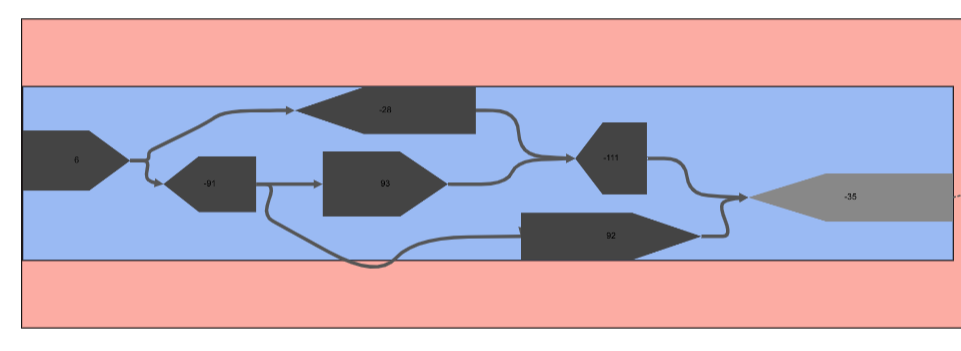

### 3.2. Double-check edge locations in BACT1

Like with CAMP, figure out what's up with the disconnected sections of the graph.

In [22]:
# Copied from MetagenomeScope
dc_node_tbl = """78	46,364 bp	+	37.16%
79	46,364 bp	+	37.16%
-179	46,521 bp	-	36.76%
-178	33,558 bp	-	36.93%
-78	46,364 bp	-	37.16%
-79	46,364 bp	-	37.16%
179	46,521 bp	+	36.76%
178	33,558 bp	+	36.93%
127	105,027 bp	+	36.74%
-168	65,017 bp	-	36.83%
128	105,027 bp	+	36.74%
-127	105,027 bp	-	36.74%
168	65,017 bp	+	36.83%
-128	105,027 bp	-	36.74%
216	76,608 bp	+	34.75%
-216	76,608 bp	-	34.75%
223	72,604 bp	+	37.79%
-223	72,604 bp	-	37.79%
163	85,567 bp	+	36.74%
-163	85,567 bp	-	36.74%
217	76,608 bp	+	34.74%
-217	76,608 bp	-	34.74%
186	63,836 bp	+	37.42%
-186	63,836 bp	-	37.42%
64	61,374 bp	+	37.25%
-64	61,374 bp	-	37.25%"""

dc_contigs = set()
for row in dc_node_tbl.splitlines():
    nodename = row.strip().split()[0]
    if nodename[0] == "-":
        dc_contigs.add(nodename[1:])
    else:
        dc_contigs.add(nodename)
dc_contigs

{'127',
 '128',
 '163',
 '168',
 '178',
 '179',
 '186',
 '216',
 '217',
 '223',
 '64',
 '78',
 '79'}

In [24]:
afp = "phasing-data/smoothed-reads/edge_1671_lja_cf_10x_p1pct_delignore_vrlow/seq2mag.sam"
f = pysam.AlignmentFile(afp)
for aln in f.fetch():
    contig_name = aln.query_name
    if contig_name in dc_contigs:
        print(contig_name)
        print(aln.get_blocks())
#     else:
#         if set(range(aln.get_blocks()[0][0], aln.get_blocks()[0][1])) & set(range(0, 101488)):
#             print(contig_name, aln.get_blocks(), "overlaps with beginning")

216
[(1281887, 1281927), (1281929, 1358497)]
127
[(190582, 295609)]
223
[(352798, 425402)]
168
[(238928, 303945)]
163
[(97145, 182533), (182536, 182715)]
217
[(1281887, 1281927), (1281929, 1358497)]
186
[(11241, 75077)]
78
[(1443454, 1489818)]
79
[(1443454, 1489818)]
128
[(190582, 295609)]
64
[(13703, 75077)]
179
[(1413410, 1414357), (1414358, 1459932)]
178
[(1426374, 1459932)]
